In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from scipy import stats
sns.set_theme(style='darkgrid', palette='colorblind')
plt.rcParams['figure.figsize'] = (28, 10)
plt.rcParams['font.size'] = 20

In [ ]:
data_dir = pathlib.Path('/lab/processed-data/EXP_JSM002_NGN2_DIV25_wholeplate')
data = pd.read_csv(data_dir / '2022-12-12_tdp43_analysis'/'2022-12-12_tdp43_analysisImage.csv')

rows = ['B', 'C', 'D', 'E', 'F', 'G']
# cols = ['NTC', 'MG132, 4hrs', 'MG132, 6hrs', 'MG132, 24hrs', 'MG132, 24hrs']
cols = ['NTC', 'B2, 4hrs', 'B2, 6hrs', 'B2, 24hrs', 'B2, 24hrs']
measurement = 'Intensity_MeanIntensity_'
channels = ['TDP43_corrected', 'pTDP43_corrected']

fig, ax = plt.subplots(len(channels), len(cols))

for i_ch, ch in enumerate(channels):
    nuclei = data['Median_nuclei_' 
                                + measurement + channels[i_ch]]
    soma = data['Median_cytoplasm_outlines_' 
                                + measurement + channels[i_ch]]
    soma = soma - nuclei

    y_min = np.min([nuclei.min(), soma.min()])
    y_max = np.max([nuclei.max(), soma.max()])

    for i_col, col in enumerate(cols):
        wells = np.arange(i_col+5,60,10)

        ax[i_ch,i_col].plot(nuclei.iloc[wells,])
        ax[i_ch,i_col].plot(soma.iloc[wells,])
        # ax[0,i_col].xticklabels('2')
        ax[i_ch,i_col].set_ylim([y_min-(y_max*0.1), y_max+(y_max*0.1)])
        ax[i_ch,i_col].set_title(col)
        ax[i_ch,i_col].set_xticks(wells)
        ax[i_ch,i_col].set_xticklabels(rows)

    ax[i_ch,i_col].legend({'nucleus', 'cytoplasm'})
ax[0,0].set_ylabel('TDP43')
ax[1,0].set_ylabel('pTDP43')
    

In [4]:
data_dir = pathlib.Path('/lab/processed-data/EXP_JSM002_NGN2_DIV25_wholeplate')
image_data = pd.read_csv(data_dir / 
                         '2022-12-12_tdp43_analysis'/
                         '2022-12-12_tdp43_analysisImage.csv')
soma_data = pd.read_csv(data_dir / 
                        '2022-12-12_tdp43_analysis'/
                        '2022-12-12_tdp43_analysiscytoplasm_outlines.csv')
nuclei_data = pd.read_csv(data_dir / 
                          '2022-12-12_tdp43_analysis'/
                          '2022-12-12_tdp43_analysisnuclei.csv')

measurement = 'Intensity_IntegratedIntensity_'
channels = ['TDP43_corrected', 'pTDP43_corrected']

ratio_data = pd.DataFrame(index = soma_data.index, 
                          columns = channels)
n_cells = soma_data.shape[0]
ratio_data['row'] = np.zeros(n_cells)
ratio_data['col'] = np.zeros(n_cells)
ratio_data['ImageNumber'] = soma_data['ImageNumber']

# Create ratio data
for ch in channels:
    ratio_data[ch] = ((soma_data[measurement + ch] - 
                       nuclei_data[measurement + ch]) / 
                      nuclei_data[measurement + ch])
    ratio_data[ch].loc[ratio_data['ImageNumber'] == 1] = 1

# Assign each cell a row & column index
for i_cell in np.arange(n_cells):
    ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][25]
    ratio_data['col'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][26:28]

# # Remove first image, which is unlabeled
# ratio_data = ratio_data.drop(index=1)
# n_cells = ratio_data.shape[0]
# ratio_data.index = np.arange(n_cells)

z_ratio_data = ratio_data[channels].copy()
z_ratio_data[channels] = stats.zscore(z_ratio_data, axis=0)
drop_rows = (z_ratio_data > 8).any(axis=1)
ratio_data = ratio_data.drop(index = ratio_data.index[drop_rows])
n_cells = ratio_data.shape[0]
ratio_data.index = np.arange(n_cells)

/tmp/ipykernel_2904/1428985819.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_data[ch].loc[ratio_data['ImageNumber'] == 1] = 1
/tmp/ipykernel_2904/1428985819.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][25]
/tmp/ipykernel_2904/1428985819.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_data['col'].iloc[i_cell] = soma_data['FileName_DA

/tmp/ipykernel_2904/3332281913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['well'] = data['row'] + data['col']


Text(0.5, 0.98, 'All wells (independently) in cols 2 & 7')

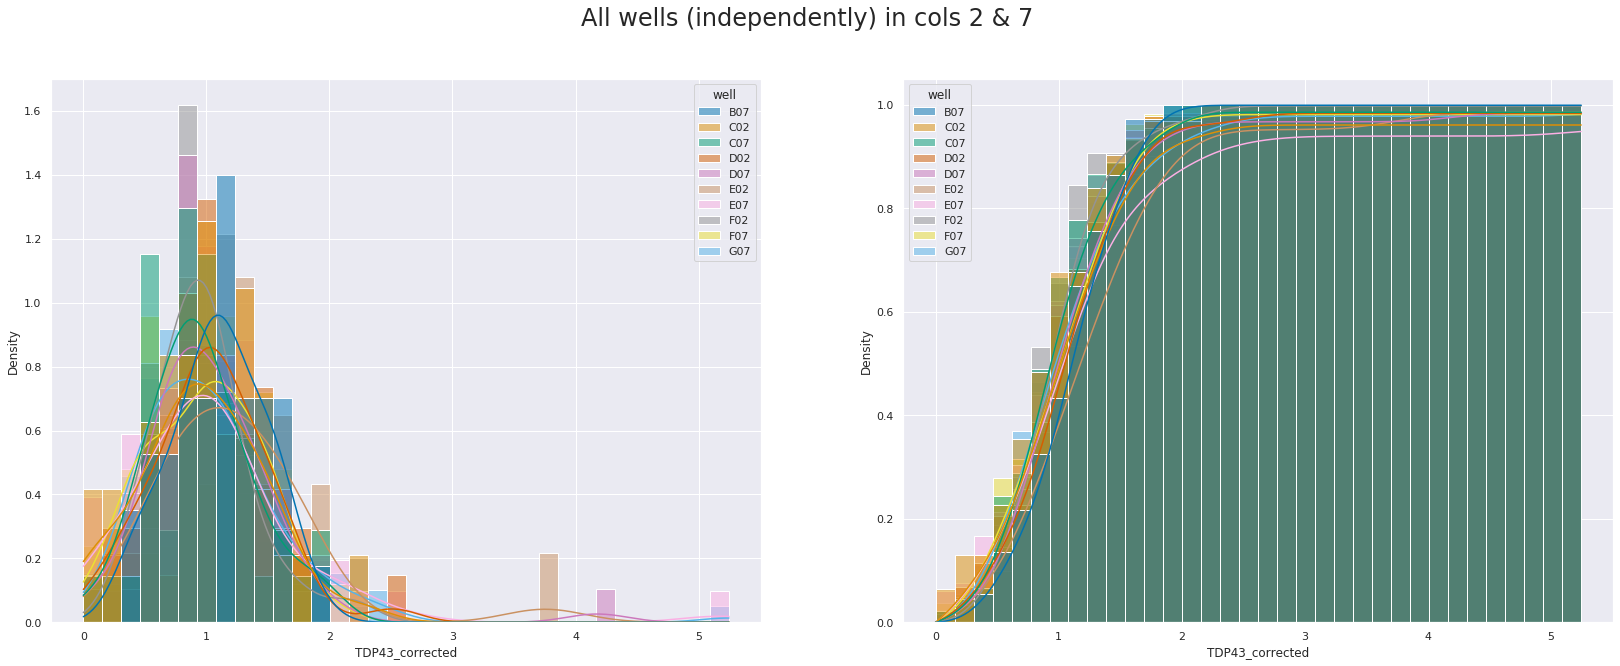

In [5]:
data = ratio_data.query('col==["02","07"]')
data['well'] = data['row'] + data['col']
data = data.drop(data.index[data['ImageNumber']==1]).drop(data.index[data['ImageNumber']==51])
fig, axs = plt.subplots(1,2)
# sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='col', kde=True, common_bins=True, stat='density', common_norm=False)
sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='well', kde=True, common_bins=True, stat='density', common_norm=False)
sns.histplot(ax=axs[1], data=data, x='TDP43_corrected', hue='well', kde=True, common_bins=True, stat='density', common_norm=False, cumulative=True)
# plt.suptitle('Cols 2 & 7, pooled within col')
plt.suptitle('All wells (independently) in cols 2 & 7')

Text(0.5, 1.0, 'pTDP-43 ratio, EXP_JSM002_NGN2_DIV25_wholeplate')

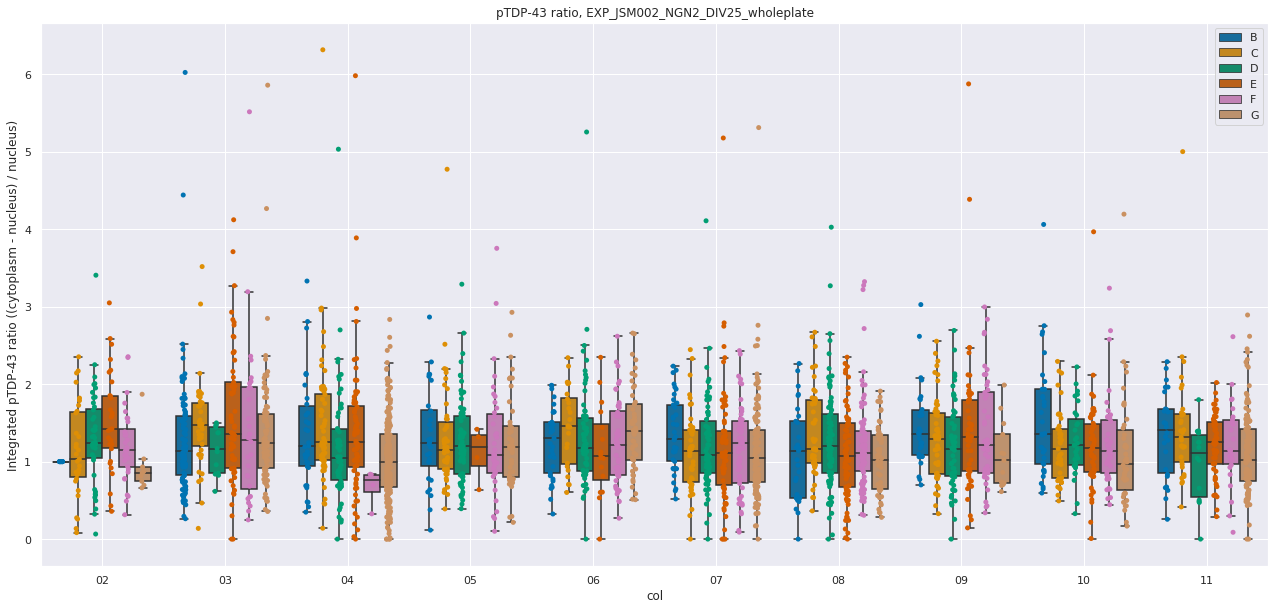

In [11]:
bplot = sns.boxplot(ratio_data,
                    x = 'col',
                    y = channels[1],
                    hue = 'row',
                    showfliers=False)
bplot = sns.stripplot(ratio_data,
                    x = 'col',
                    y = channels[1],
                    hue = 'row',
                    dodge=True)
bplot.xaxis.grid(True)
handles, labels = bplot.get_legend_handles_labels()
l = plt.legend(handles[0:6], labels[0:6])
plt.ylabel('Integrated pTDP-43 ratio ((cytoplasm - nucleus) / nucleus)')
plt.title('pTDP-43 ratio, EXP_JSM002_NGN2_DIV25_wholeplate')

/tmp/ipykernel_2904/947822297.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['well'] = data['row'] + data['col']
/tmp/ipykernel_2904/947822297.py:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.lineplot(data, x='row', y=channels[0], hue='col', palette=pal, errorbar='se')


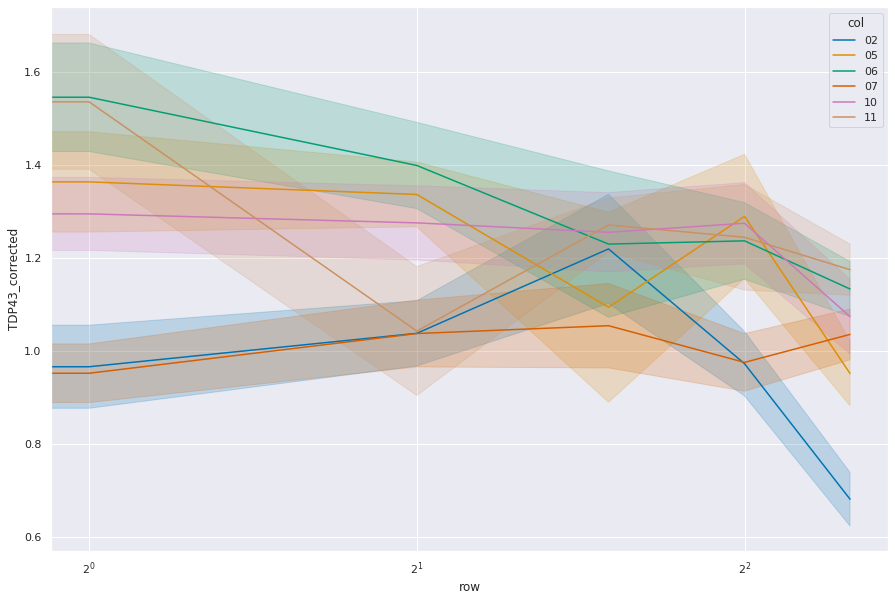

In [15]:
sns.set_theme(style='darkgrid', palette='colorblind')
pal = sns.color_palette("colorblind").as_hex()
plt.rcParams['figure.figsize'] = (15, 10)
data = ratio_data.query('col==["02","05","06","07","10","11"]')
data['well'] = data['row'] + data['col']
sns.lineplot(data, x='row', y=channels[0], hue='col', palette=pal, errorbar='se')
plt.xscale('log', basex=2)